https://www.kaggle.com/nageshsingh/mask-and-social-distancing-detection-using-vgg19/notebook

https://www.kaggle.com/elizabethsoelistio/face-mask-detection-using-fasterrcnn-and-pytorch

# loading data

In [ ]:
#Dataset for read only
import os
from xml.etree import ElementTree as et
#Data processing and data visualization with bounding boxes
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Global used to return all file paths with speicifc pattern
import glob
#Linear Algebra
import numpy as np # linear algebra
#Parsing HTML and XML Documents (We use the XML docs)
from bs4 import BeautifulSoup
#Model
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2
import cv2
import tensorflow as tf
from PIL import Image

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/face-mask-detection

 99% 394M/398M [00:02<00:00, 178MB/s]
100% 398M/398M [00:02<00:00, 192MB/s]


In [ ]:
! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
! kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 97% 322M/330M [00:01<00:00, 181MB/s]
100% 330M/330M [00:01<00:00, 184MB/s]
 94% 194M/207M [00:01<00:00, 152MB/s]
100% 207M/207M [00:01<00:00, 152MB/s]


In [ ]:
! mkdir kaggle_853
! unzip face-mask-detection.zip -d kaggle_853

Archive:  face-mask-detection.zip
  inflating: kaggle_853/annotations/maksssksksss0.xml  
  inflating: kaggle_853/annotations/maksssksksss1.xml  
  inflating: kaggle_853/annotations/maksssksksss10.xml  
  inflating: kaggle_853/annotations/maksssksksss100.xml  
  inflating: kaggle_853/annotations/maksssksksss101.xml  
  inflating: kaggle_853/annotations/maksssksksss102.xml  
  inflating: kaggle_853/annotations/maksssksksss103.xml  
  inflating: kaggle_853/annotations/maksssksksss104.xml  
  inflating: kaggle_853/annotations/maksssksksss105.xml  
  inflating: kaggle_853/annotations/maksssksksss106.xml  
  inflating: kaggle_853/annotations/maksssksksss107.xml  
  inflating: kaggle_853/annotations/maksssksksss108.xml  
  inflating: kaggle_853/annotations/maksssksksss109.xml  
  inflating: kaggle_853/annotations/maksssksksss11.xml  
  inflating: kaggle_853/annotations/maksssksksss110.xml  
  inflating: kaggle_853/annotations/maksssksksss111.xml  
  inflating: kaggle_853/annotations/maksssks

In [ ]:
! mkdir kaggle_12k
! unzip face-mask-12k-images-dataset.zip -d kaggle_12k

串流輸出內容已截斷至最後 5000 行。
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: kaggle_12k/Face Mask Dataset/Train/WithoutM

In [ ]:
! mkdir kaggle_1k
! unzip covid-face-mask-detection-dataset.zip -d kaggle_1k

Archive:  covid-face-mask-detection-dataset.zip
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2070.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2072.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2083.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2085.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2086.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2110.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2113.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2130.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2132.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2135.jpg  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2154.png  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2158.png  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2159.png  
  inflating: kaggle_1k/New Masks Dataset/Test/Mask/2160.png  
  inflating: kaggle_1

In [ ]:
images_dir = 'kaggle_853/images/'
annotations_dir = 'kaggle_853/annotations/'

In [ ]:
class FaceMaskDataset853(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # Sorting images and checking extension filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # Classes divided into 4 with background labeled 0
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        self.img_name = self.imgs[idx]
        self.image_path = os.path.join(self.images_dir, self.img_name)

        # Reading the images    
        img = cv2.imread(self.image_path)
        
        # Converting size and color
        img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        # Image Normalization
        img_res /= 255.0
        
        # Annotate files
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # CV2 shaping height and width sizes
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Bounding box coordinates for XML files
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # Corrected for image size given
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["image_name"] = self.img_name

        if self.transforms:
            
            sample = self.transforms(image = img_res,
            bboxes = target['boxes'],
            labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Checking dataset
dataset = FaceMaskDataset853(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# Testing image shape
img, target = dataset[11]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[ 86.8000,  28.8711, 100.8000,  50.7733],
        [115.3600,  34.8444, 127.6800,  57.7422],
        [185.9200,  66.7022, 193.7600,  80.6400],
        [202.7200,  67.6978, 210.5600,  81.6356],
        [149.5200,  71.6800, 155.6800,  82.6311]]), 'labels': tensor([2, 2, 2, 2, 1]), 'area': tensor([306.6311, 282.1006, 109.2721, 109.2722,  67.4587]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([11]), 'image_name': 'maksssksksss108.png'}


## 853 資料集的照片檢視

In [ ]:
#Visualizing bounding box
def plot_img_bbox(img_res, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig = plt.figure(figsize=(8, 6))
    a = fig.subplots(1,1)
    a.imshow(img_res)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none')

        # Drawing the bounding box on images
        a.add_patch(rect)
    plt.show()

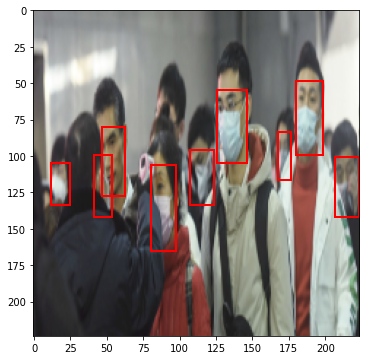

In [ ]:
# Plotting bounding box on the images
img_res, target = dataset[1]
plot_img_bbox(img_res, target)

In [ ]:
from shutil import copyfile
from os import listdir
from os.path import isfile, isdir, join

In [ ]:
import shutil
import random
seed = 5566

# 合併資料集

In [ ]:
## 新增 train, test 目錄
## validation dir

## 不包含 853 資料集
os.mkdir("train_nocrop") 
os.mkdir("train_nocrop/mask") 
os.mkdir("train_nocrop/withoutmask") 

os.mkdir("test_nocrop") 
os.mkdir("test_nocrop/mask") 
os.mkdir("test_nocrop/withoutmask") 

os.mkdir("validation_nocrop") 
os.mkdir("validation_nocrop/mask") 
os.mkdir("validation_nocrop/withoutmask") 

## 僅 853 資料集
os.mkdir("train_crop") 
os.mkdir("train_crop/mask") 
os.mkdir("train_crop/badmask") 
os.mkdir("train_crop/withoutmask") 

os.mkdir("test_crop") 
os.mkdir("test_crop/mask") 
os.mkdir("test_crop/badmask") 
os.mkdir("test_crop/withoutmask") 

os.mkdir("validation_crop") 
os.mkdir("validation_crop/mask") 
os.mkdir("validation_crop/badmask") 
os.mkdir("validation_crop/withoutmask") 

## final資料 
os.mkdir("train") 
os.mkdir("train/mask") 
os.mkdir("train/withoutmask") 
os.mkdir("train/badmask") 

os.mkdir("test") 
os.mkdir("test/mask") 
os.mkdir("test/withoutmask") 
os.mkdir("test/badmask") 

os.mkdir("validation") 
os.mkdir("validation/mask") 
os.mkdir("validation/withoutmask") 
os.mkdir("validation/badmask") 


In [ ]:
## 全部資料 
os.mkdir("train_all") 
os.mkdir("train_all/mask") 
os.mkdir("train_all/withoutmask") 

os.mkdir("test_all") 
os.mkdir("test_all/mask") 
os.mkdir("test_all/withoutmask") 

os.mkdir("validation_all") 
os.mkdir("validation_all/mask") 
os.mkdir("validation_all/withoutmask") 

In [ ]:
## train mask
# 指定要列出所有檔案的目錄
def copy_dir(origin_dirs, des_dir):
  for origin_dir in origin_dirs:
    # 取得所有檔案與子目錄名稱
    files = listdir(origin_dir)
    # 以迴圈處理
    for f in files:
      # 產生檔案的絕對路徑
      origin_file = join(origin_dir, f)
      copyfile(origin_file, join(des_dir, f))
    print(f"len of {des_dir}: {len(listdir(des_dir))}")
# print(len(listdir("train_nocrop/mask")))

In [ ]:
des_dir = "train_nocrop/mask"
origin_dirs =["kaggle_12k/Face Mask Dataset/Train/WithMask", "kaggle_12k/Face Mask Dataset/Validation/WithMask", "kaggle_1k/New Masks Dataset/Train/Mask", "kaggle_1k/New Masks Dataset/Validation/Mask"] 
copy_dir(origin_dirs=origin_dirs, des_dir=des_dir)

len of train_nocrop/mask: 5000
len of train_nocrop/mask: 5400
len of train_nocrop/mask: 5697
len of train_nocrop/mask: 5850


In [ ]:
des_dir = "train_nocrop/withoutmask"
origin_dirs =["kaggle_12k/Face Mask Dataset/Train/WithoutMask", "kaggle_12k/Face Mask Dataset/Validation/WithoutMask", "kaggle_1k/New Masks Dataset/Train/Non Mask", "kaggle_1k/New Masks Dataset/Validation/Non Mask"] 
copy_dir(origin_dirs=origin_dirs, des_dir=des_dir)

len of train_nocrop/withoutmask: 5000
len of train_nocrop/withoutmask: 5400
len of train_nocrop/withoutmask: 5700
len of train_nocrop/withoutmask: 5853


In [ ]:
des_dir = "test_nocrop/mask"
origin_dirs =["kaggle_1k/New Masks Dataset/Test/Mask", "kaggle_12k/Face Mask Dataset/Test/WithMask"]
copy_dir(origin_dirs=origin_dirs, des_dir=des_dir)

len of test_nocrop/mask: 50
len of test_nocrop/mask: 533


In [ ]:
des_dir = "test_nocrop/withoutmask"
origin_dirs = ["kaggle_1k/New Masks Dataset/Test/Non Mask", "kaggle_12k/Face Mask Dataset/Test/WithoutMask"]
copy_dir(origin_dirs=origin_dirs, des_dir=des_dir)

len of test_nocrop/withoutmask: 50
len of test_nocrop/withoutmask: 559


## 切割 validation 資料集

In [ ]:
def cut_validation(train_dir, val_dir):
  train_masks = listdir(train_dir)
  val_masks = random.sample(train_masks, k=round(len(train_masks)*0.2))
  for val_mask in val_masks:
    shutil.move(join(train_dir, val_mask), join(val_dir, val_mask))
  print(f"len of {train_dir}: {len(listdir(train_dir))}")
  print(f"len of {val_dir}: {len(listdir(val_dir))}")

In [ ]:
cut_validation(train_dir="train_nocrop/mask", val_dir="validation_nocrop/mask")

len of train_nocrop/mask: 4680
len of validation_nocrop/mask: 1170


In [ ]:
cut_validation(train_dir="train_nocrop/withoutmask", val_dir="validation_nocrop/withoutmask")

len of train_nocrop/withoutmask: 4682
len of validation_nocrop/withoutmask: 1171


In [ ]:
print("train_nocrop/mask", len(listdir("train_nocrop/mask")))
print("train_nocrop/withoutmask", len(listdir("train_nocrop/withoutmask")))
print("val_nocrop/mask", len(listdir("validation_nocrop/mask")))
print("val_nocrop/withoutmask", len(listdir("validation_nocrop/withoutmask")))
print("test_nocrop/mask", len(listdir("test_nocrop/mask")))
print("test_nocrop/withoutmask", len(listdir("test_nocrop/withoutmask")))

train_nocrop/mask 4680
train_nocrop/withoutmask 4682
val_nocrop/mask 1170
val_nocrop/withoutmask 1171
test_nocrop/mask 533
test_nocrop/withoutmask 559


In [ ]:
def clear_dir(des_dir):
  for f in listdir(des_dir):
    os.remove(os.path.join(des_dir, f))
  print(f'len of {des_dir}: {len(listdir(des_dir))}')
  # print(f"len of {val_dir}: {len(listdir(val_dir))}")

## 將 853 資料集依照人頭標記切下

In [ ]:
## crop img
def crop_img_bbox(img, target, save=False, test=False):
    # crop the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    ## img is from cv2.read()
    # plt.imshow(img)
    # plt.show()
    c = 0
    for box in (target['boxes']):
      if test and target["labels"][c] != 3:
        continue
      # crop_img = img[y:y+h, x:x+w]
      crop_img = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
      group = random.choices(["train", "validation", "test"], weights=[5.5/(5.5+1.1+0.5), 1.1/(5.5+1.1+0.5), 0.5/(5.5+1.1+0.5)])[0]
      if "maksssksksss11" in target["image_name"][:-4]:
        group = "test"
      if target["labels"][c] == 2:
        label = "mask"
      elif target["labels"][c] == 1:
        label = "withoutmask"
      else:
        label = "badmask"
      file_name = f'{group}_crop/{label}/crop_{target["image_name"][:-4]}_{c}.jpg'
      if not crop_img.size: 
        continue
      cv2.imwrite(file_name, cv2.convertScaleAbs(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), alpha=(255.0)))
      # cv2.imwrite(file_name, crop_img)
      # plt.axis('off')
      # plt.imsave(file_name, crop_img)
      if test:
        plt.imshow(crop_img)
        print(file_name)
        plt.show()
        # Reading the images    
        img = cv2.imread(file_name)
        
        # Converting size and color
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (128, 128), cv2.INTER_AREA)
        
        # Image Normalization
        img_res /= 255.0
        plt.imshow(img_res)
        plt.show()
        clear_dir(f'{group}_crop/{label}')
      c+=1

test_crop/badmask/crop_maksssksksss11_0.jpg


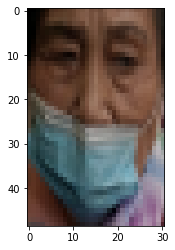

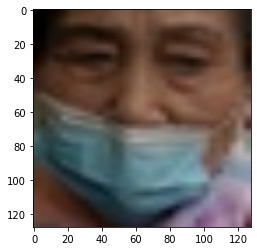

len of test_crop/badmask: 0
test_crop/badmask/crop_maksssksksss112_0.jpg


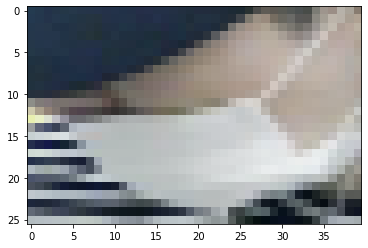

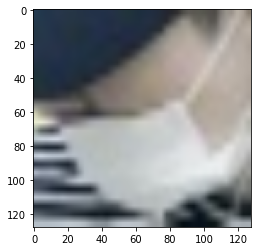

len of test_crop/badmask: 0
validation_crop/badmask/crop_maksssksksss130_0.jpg


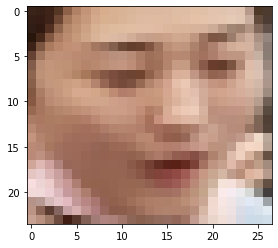

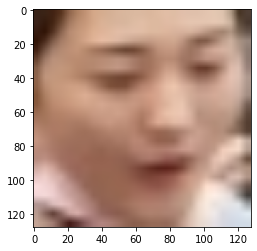

len of validation_crop/badmask: 0
train_crop/badmask/crop_maksssksksss132_0.jpg


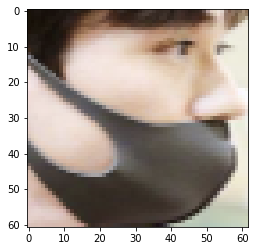

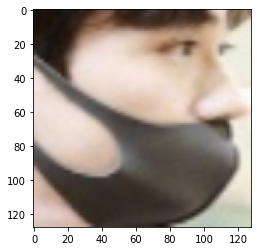

len of train_crop/badmask: 0
validation_crop/badmask/crop_maksssksksss145_0.jpg


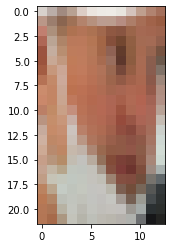

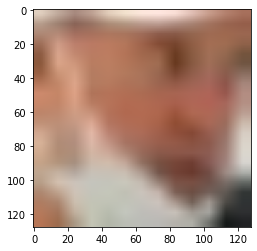

len of validation_crop/badmask: 0


In [ ]:
for i in range(100):
  img_res, target = dataset[i]
  crop_img_bbox(img_res, target, save=0, test=1)

In [ ]:
for n in range(len(dataset)):
  img_res, target =dataset[n]
  crop_img_bbox(img_res, target, save=1)

In [ ]:
print(f"len of train_crop/mask: {len(listdir('train_crop/mask'))}")
print(f"len of train_crop/withoutmask: {len(listdir('train_crop/withoutmask'))}")
print(f"len of train_crop/badmask: {len(listdir('train_crop/badmask'))}")

len of train_crop/mask: 2472
len of train_crop/withoutmask: 540
len of train_crop/badmask: 94


In [ ]:
copy_dir(origin_dirs=["train_nocrop/mask", "train_crop/mask"], des_dir="train_all/mask")
copy_dir(origin_dirs=["train_nocrop/withoutmask", "train_crop/withoutmask", "train_crop/badmask"], des_dir="train_all/withoutmask")
print()
copy_dir(origin_dirs=["validation_nocrop/mask", "validation_crop/mask"], des_dir="validation_all/mask")
copy_dir(origin_dirs=["validation_nocrop/withoutmask", "validation_crop/withoutmask", "validation_crop/badmask"], des_dir="validation_all/withoutmask")
print()
copy_dir(origin_dirs=["test_nocrop/mask", "test_crop/mask"], des_dir="test_all/mask")
copy_dir(origin_dirs=["test_nocrop/withoutmask", "test_crop/withoutmask", "test_crop/badmask"], des_dir="test_all/withoutmask")

len of train_all/mask: 4680
len of train_all/mask: 7152
len of train_all/withoutmask: 4682
len of train_all/withoutmask: 5222
len of train_all/withoutmask: 5316

len of validation_all/mask: 1170
len of validation_all/mask: 1654
len of validation_all/withoutmask: 1171
len of validation_all/withoutmask: 1275
len of validation_all/withoutmask: 1291

len of test_all/mask: 533
len of test_all/mask: 809
len of test_all/withoutmask: 559
len of test_all/withoutmask: 632
len of test_all/withoutmask: 645


# data augmentation

In [ ]:
# import the Python Image processing Library
from PIL import Image, ImageOps

In [ ]:
def augmentX9(dir, file_name):
  # Create an Image object from an Image
  colorImage  = Image.open(f"{dir}/{file_name}")
  for i in [-35, -25, -15, -5, 5, 15, 25, 35]:
    # Rotate it by i degrees
    rotated = colorImage.rotate(i)
    rotated.save(f"{dir}/rotate{i}_{file_name}")
  mirrored = ImageOps.mirror(colorImage)
  mirrored.save(f"{dir}/mirror_{file_name}")

In [ ]:
for badmask in listdir('train_crop/badmask'):
  augmentX9("train_crop/badmask", badmask)

In [ ]:
print(f"len of train_crop/mask: {len(listdir('train_crop/mask'))}")
print(f"len of train_crop/withoutmask: {len(listdir('train_crop/withoutmask'))}")
print(f"len of train_crop/badmask: {len(listdir('train_crop/badmask'))}")

len of train_crop/mask: 2472
len of train_crop/withoutmask: 540
len of train_crop/badmask: 940


In [ ]:
for group in ["train", "validation", "test"]:
  for label in ["mask", "withoutmask", "badmask"]:
    clear_dir(f"{group}/{label}")
print()
copy_dir(origin_dirs=["train_nocrop/mask"], des_dir="train/mask")
copy_dir(origin_dirs=["train_nocrop/withoutmask"], des_dir="train/withoutmask")
copy_dir(origin_dirs=["train_crop/badmask"], des_dir="train/badmask")
print()
copy_dir(origin_dirs=["validation_nocrop/mask"], des_dir="validation/mask")
copy_dir(origin_dirs=["validation_nocrop/withoutmask"], des_dir="validation/withoutmask")
copy_dir(origin_dirs=["validation_crop/badmask"], des_dir="validation/badmask")
print()
copy_dir(origin_dirs=["test_nocrop/mask"], des_dir="test/mask")
copy_dir(origin_dirs=["test_nocrop/withoutmask"], des_dir="test/withoutmask")
copy_dir(origin_dirs=["test_crop/badmask"], des_dir="test/badmask")

len of train/mask: 0
len of train/withoutmask: 0
len of train/badmask: 0
len of validation/mask: 0
len of validation/withoutmask: 0
len of validation/badmask: 0
len of test/mask: 0
len of test/withoutmask: 0
len of test/badmask: 0

len of train/mask: 4680
len of train/withoutmask: 4682
len of train/badmask: 940

len of validation/mask: 1170
len of validation/withoutmask: 1171
len of validation/badmask: 16

len of test/mask: 533
len of test/withoutmask: 559
len of test/badmask: 13


In [ ]:
print("train/mask", len(listdir("train/mask")))
print("train/withoutmask", len(listdir("train/withoutmask")))
print("train/badmask", len(listdir("train/badmask")))
print("val/mask", len(listdir("validation/mask")))
print("val/withoutmask", len(listdir("validation/withoutmask")))
print("val/badmask", len(listdir("validation/badmask")))
print("test/mask", len(listdir("test/mask")))
print("test/withoutmask", len(listdir("test/withoutmask")))
print("test/badmask", len(listdir("test/badmask")))

train/mask 4680
train/withoutmask 4682
train/badmask 920
val/mask 1170
val/withoutmask 1171
val/badmask 19
test/mask 533
test/withoutmask 559
test/badmask 12


# models
## VGG models
VGG_model -> phase 1  
all_VGG_model -> phase 2  
final_VGG_model -> phase 3

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Load train and test set
train_dir = 'train_nocrop'
test_dir = 'test_nocrop'
val_dir = 'validation_nocrop'
# train_dir = 'kaggle_12k/Face Mask Dataset/Train'
# test_dir = 'kaggle_12k/Face Mask Dataset/Test'
# val_dir = 'kaggle_12k/Face Mask Dataset/Validation'

In [ ]:
 ! tensorflow --version

/bin/bash: tensorflow: command not found


In [ ]:
all_train_dir = 'train_all'
all_test_dir = 'test_all'
all_val_dir = 'validation_all'

In [ ]:
final_train_dir = 'train'
final_test_dir = 'test'
final_val_dir = 'validation'

In [ ]:
# Data augmentation
seed = 5566
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)

# val_datagen = ImageDataGenerator(rescale=1.0/255)
# val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 9362 images belonging to 2 classes.
Found 2341 images belonging to 2 classes.
Found 1092 images belonging to 2 classes.


In [ ]:
# Data augmentation
seed = 5566
all_train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
all_train_generator = all_train_datagen.flow_from_directory(directory=all_train_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)
all_val_generator = all_train_datagen.flow_from_directory(directory=all_val_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)

# val_datagen = ImageDataGenerator(rescale=1.0/255)
# val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

all_test_datagen = ImageDataGenerator(rescale=1.0/255)
all_test_generator = all_train_datagen.flow_from_directory(directory=all_test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 12463 images belonging to 2 classes.
Found 2938 images belonging to 2 classes.
Found 1466 images belonging to 2 classes.


In [ ]:
# Data augmentation
seed = 5566
final_train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
final_train_generator = final_train_datagen.flow_from_directory(directory=final_train_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)
final_val_generator = final_train_datagen.flow_from_directory(directory=final_val_dir,target_size=(128,128),class_mode='categorical',batch_size=32, seed=seed)

# val_datagen = ImageDataGenerator(rescale=1.0/255)
# val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

final_test_datagen = ImageDataGenerator(rescale=1.0/255)
final_test_generator = final_test_datagen.flow_from_directory(directory=final_test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10302 images belonging to 3 classes.
Found 2357 images belonging to 3 classes.
Found 1105 images belonging to 3 classes.


In [ ]:
vgg_checkpoint = "VGG.h5"
vgg_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=vgg_checkpoint,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
VGG_model = Sequential()
VGG_model.add(vgg19)
VGG_model.add(Flatten())
VGG_model.add(Dense(2,activation='sigmoid'))
VGG_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
all_checkpoint = "VGG_all.h5"
all_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=all_checkpoint,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]
all_vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in all_vgg19.layers:
    layer.trainable = False
    
all_VGG_model = Sequential()
all_VGG_model.add(all_vgg19)
all_VGG_model.add(Flatten())
all_VGG_model.add(Dense(2,activation='sigmoid'))
all_VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
final_checkpoint = "VGG_final.h5"
final_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=final_checkpoint,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

final_vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in final_vgg19.layers:
    layer.trainable = False
    
final_VGG_model = Sequential()
final_VGG_model.add(final_vgg19)
final_VGG_model.add(Flatten())
final_VGG_model.add(Dense(3,activation='softmax'))
final_VGG_model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 20,048,963
Trainable params: 24,579
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
VGG_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy", tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])
all_VGG_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy", tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])

## training

In [ ]:
VGG_record = []
VGG_history = VGG_model.fit(train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32,
                              callbacks=vgg_callbacks)
VGG_record.append(VGG_history)
VGG_model.load_weights(vgg_checkpoint)

Epoch 1/20
9/9 [==============================] - 77s 9s/step - loss: 0.5293 - accuracy: 0.7188 - precision: 0.9062 - recall: 0.4028 - val_loss: 0.3580 - val_accuracy: 0.8750 - val_precision: 0.9444 - val_recall: 0.5312
Epoch 2/20
9/9 [==============================] - 77s 9s/step - loss: 0.3005 - accuracy: 0.8750 - precision: 0.9598 - recall: 0.6632 - val_loss: 0.2982 - val_accuracy: 0.8750 - val_precision: 0.9000 - val_recall: 0.7031
Epoch 3/20
9/9 [==============================] - 76s 9s/step - loss: 0.1849 - accuracy: 0.9479 - precision: 0.9786 - recall: 0.7951 - val_loss: 0.1771 - val_accuracy: 0.9531 - val_precision: 0.9808 - val_recall: 0.7969
Epoch 4/20
9/9 [==============================] - 76s 9s/step - loss: 0.2023 - accuracy: 0.9167 - precision: 0.9520 - recall: 0.8264 - val_loss: 0.1989 - val_accuracy: 0.9062 - val_precision: 1.0000 - val_recall: 0.8281
Epoch 5/20
9/9 [==============================] - 77s 9s/step - loss: 0.1269 - accuracy: 0.9618 - precision: 0.9803 - re

In [ ]:
all_VGG_record = []
all_VGG_history = all_VGG_model.fit(all_train_generator,
                              steps_per_epoch=len(all_train_generator)//32,
                              epochs=20,validation_data=all_val_generator,
                              validation_steps=len(all_val_generator)//32, 
                              callbacks=all_callbacks)
all_VGG_record.append(all_VGG_history)
all_VGG_model.load_weights(all_checkpoint)

Epoch 1/20
12/12 [==============================] - 97s 8s/step - loss: 0.2508 - accuracy: 0.9010 - precision_1: 0.9533 - recall_1: 0.7448 - val_loss: 0.1910 - val_accuracy: 0.9062 - val_precision_1: 0.9825 - val_recall_1: 0.8750
Epoch 2/20
12/12 [==============================] - 96s 8s/step - loss: 0.1903 - accuracy: 0.9245 - precision_1: 0.9540 - recall_1: 0.8646 - val_loss: 0.1776 - val_accuracy: 0.9375 - val_precision_1: 0.9661 - val_recall_1: 0.8906
Epoch 3/20
12/12 [==============================] - 96s 8s/step - loss: 0.1872 - accuracy: 0.9297 - precision_1: 0.9535 - recall_1: 0.8542 - val_loss: 0.2431 - val_accuracy: 0.9062 - val_precision_1: 0.9804 - val_recall_1: 0.7812
Epoch 4/20
12/12 [==============================] - 96s 8s/step - loss: 0.2036 - accuracy: 0.9375 - precision_1: 0.9660 - recall_1: 0.8151 - val_loss: 0.1449 - val_accuracy: 0.9375 - val_precision_1: 0.9821 - val_recall_1: 0.8594
Epoch 5/20
12/12 [==============================] - 93s 8s/step - loss: 0.1468 -

In [ ]:
final_VGG_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy", tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])
final_VGG_record = []
final_VGG_history = final_VGG_model.fit(final_train_generator,
                              steps_per_epoch=len(final_train_generator)//32,
                              epochs=20,validation_data=final_val_generator,
                              validation_steps=len(final_val_generator)//32, 
                              callbacks=final_callbacks)
final_VGG_record.append(final_VGG_history)
final_VGG_model.load_weights(final_checkpoint)

Epoch 1/20
10/10 [==============================] - 74s 7s/step - loss: 0.1111 - accuracy: 0.9625 - precision_1: 0.9686 - recall_1: 0.9625 - val_loss: 0.0845 - val_accuracy: 0.9688 - val_precision_1: 0.9688 - val_recall_1: 0.9688
Epoch 2/20
10/10 [==============================] - 73s 7s/step - loss: 0.0834 - accuracy: 0.9781 - precision_1: 0.9781 - recall_1: 0.9781 - val_loss: 0.0426 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/20
10/10 [==============================] - 73s 7s/step - loss: 0.1123 - accuracy: 0.9688 - precision_1: 0.9718 - recall_1: 0.9688 - val_loss: 0.0504 - val_accuracy: 0.9844 - val_precision_1: 0.9844 - val_recall_1: 0.9844
Epoch 4/20
10/10 [==============================] - 75s 8s/step - loss: 0.0945 - accuracy: 0.9625 - precision_1: 0.9686 - recall_1: 0.9625 - val_loss: 0.0247 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/20
10/10 [==============================] - 74s 7s/step - loss: 0.1354 -

## 載入人臉辨識模型並測試

In [ ]:
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

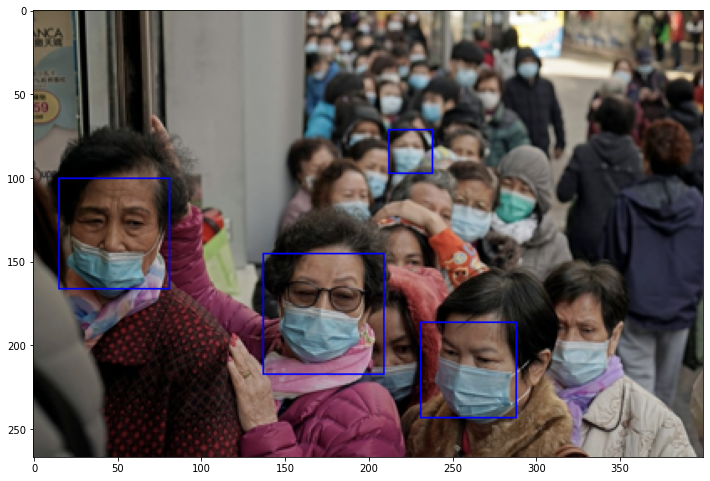

In [ ]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('kaggle_853/images/maksssksksss11.png')
# img = cv2.imread('kaggle_853/images/maksssksksss29.png')
# img = cv2.imread('validation/badmask/crop_maksssksksss132_0.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

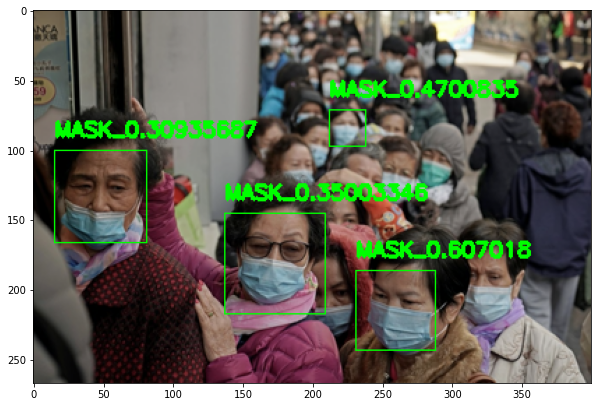

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
col_label = {0:(0,255,0),1:(255,0,0)}

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = VGG_model.predict(crop)
    cv2.putText(new_img,mask_label[mask_result.argmax()]+str("_")+str(mask_result[0][0]),(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),col_label[mask_result.argmax()],1)
plt.figure(figsize=(10,10))
plt.imshow(new_img)

In [ ]:
mask_result

array([[0.607018  , 0.16432717]], dtype=float32)

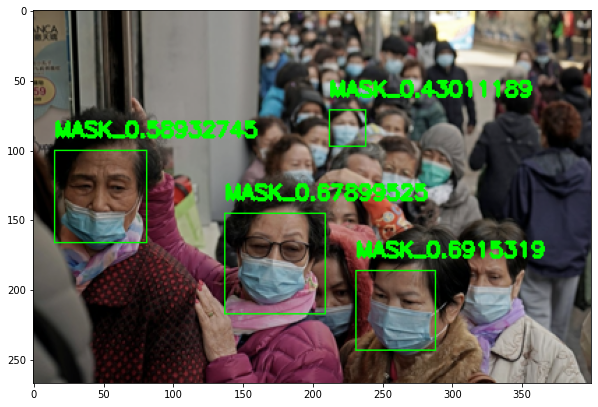

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
col_label = {0:(0,255,0),1:(255,0,0)}

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = all_VGG_model.predict(crop)
    cv2.putText(new_img,mask_label[mask_result.argmax()]+str("_")+str(mask_result[0][0]),(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),col_label[mask_result.argmax()],1)
plt.figure(figsize=(10,10))
plt.imshow(new_img)

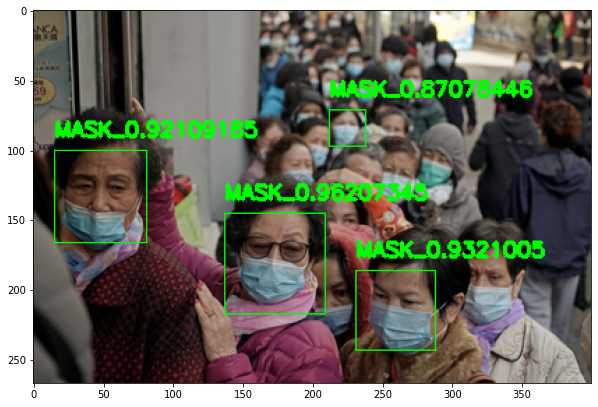

In [ ]:
mask_label = {0:'NO MASK',1:'MASK', 2:"NO MASK"}
col_label = {0:(0,255,0), 1:(0,255,0), 2:(0,255,0)}

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = final_VGG_model.predict(crop)
    cv2.putText(new_img,mask_label[mask_result.argmax()]+str("_")+str(mask_result[0][mask_result.argmax()]),(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),col_label[mask_result.argmax()],1)
plt.figure(figsize=(10,10))
plt.imshow(new_img)

In [ ]:
(loss, accuracy, precision, recall) = final_VGG_model.evaluate_generator(final_test_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


35/35 [==============================] - 231s 7s/step - loss: 0.0905 - accuracy: 0.9737 - precision_2: 0.9746 - recall_2: 0.9737


In [ ]:
print(loss, accuracy, precision, recall)

0.0905197411775589 0.9737318754196167 0.974614679813385 0.9737318754196167


In [ ]:
(loss, accuracy, precision, recall) = all_VGG_model.evaluate_generator(all_test_generator, verbose=1)
print(loss, accuracy, precision, recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


46/46 [==============================] - 311s 7s/step - loss: 0.1717 - accuracy: 0.9270 - precision_1: 0.9793 - recall_1: 0.8377
0.17167417705059052 0.9270122647285461 0.979266345500946 0.8376534581184387


In [ ]:
(loss, accuracy, precision, recall) = VGG_model.evaluate_generator(all_test_generator, verbose=1)
print(loss, accuracy, precision, recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


46/46 [==============================] - 311s 7s/step - loss: 0.2036 - accuracy: 0.9161 - precision: 0.9666 - recall: 0.8104
0.2036091387271881 0.9160982370376587 0.966639518737793 0.8103683590888977


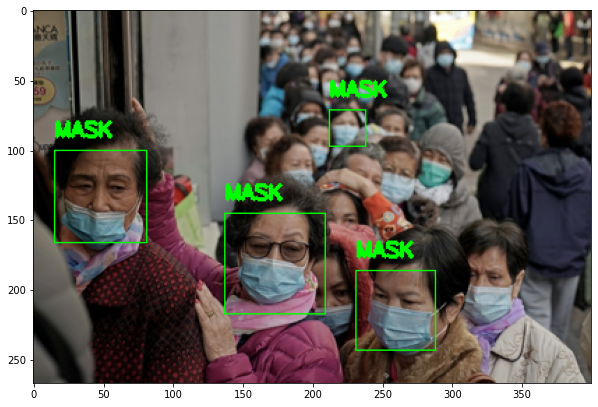

In [ ]:
MIN_DISTANCE = 130
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = VGG_model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

## ResNet model(phase 1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

In [ ]:
import os
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
net = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(128, 128, 3)),)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

headModel = net.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=net.input, outputs=headModel)

for layer in net.layers:
	layer.trainable = True

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy", tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
hr_checkpoint = "hr.h5"
hr_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=hr_checkpoint,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]
HR = model.fit(train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32, 
               callbacks=hr_callbacks)

Epoch 1/20
9/9 [==============================] - 91s 10s/step - loss: 0.4693 - accuracy: 0.7986 - precision_3: 0.7986 - recall_3: 0.7986 - val_loss: 0.7012 - val_accuracy: 0.4844 - val_precision_3: 0.4844 - val_recall_3: 0.4844
Epoch 2/20
9/9 [==============================] - 84s 9s/step - loss: 0.1329 - accuracy: 0.9549 - precision_3: 0.9549 - recall_3: 0.9549 - val_loss: 0.6897 - val_accuracy: 0.5781 - val_precision_3: 0.5781 - val_recall_3: 0.5781
Epoch 3/20
9/9 [==============================] - 83s 9s/step - loss: 0.0579 - accuracy: 0.9792 - precision_3: 0.9792 - recall_3: 0.9792 - val_loss: 0.8599 - val_accuracy: 0.4531 - val_precision_3: 0.4531 - val_recall_3: 0.4531
Epoch 4/20
9/9 [==============================] - 82s 9s/step - loss: 0.0523 - accuracy: 0.9792 - precision_3: 0.9792 - recall_3: 0.9792 - val_loss: 2.8886 - val_accuracy: 0.4375 - val_precision_3: 0.4375 - val_recall_3: 0.4375
Epoch 5/20
9/9 [==============================] - 85s 10s/step - loss: 0.0657 - accurac

## model loss

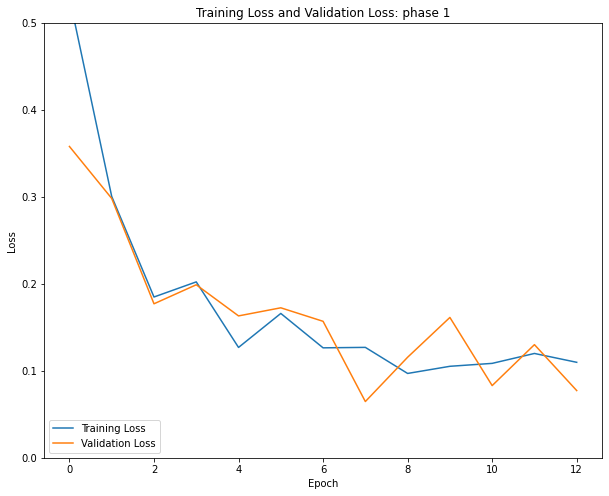

In [ ]:
N = 13

plt.figure(figsize=(10, 8))
plt.plot(np.arange(0, N), VGG_history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), VGG_history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss: phase 1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, .5)
plt.legend(loc="lower left")
plt.savefig("phase1.png")

In [ ]:
len(VGG_history.history["loss"])

13

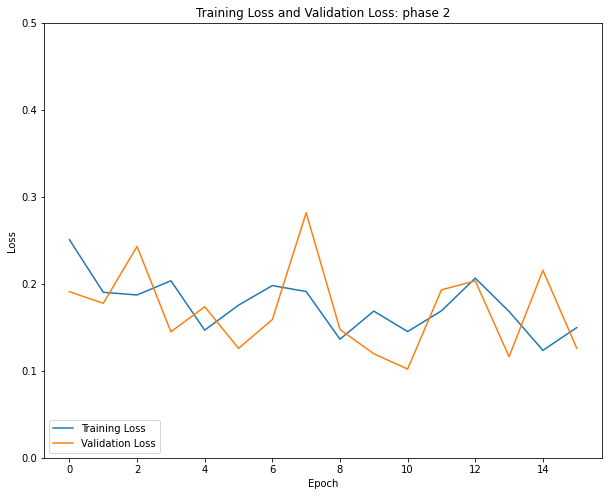

In [ ]:
N = 16

plt.figure(figsize=(10, 8))
plt.plot(np.arange(0, N), all_VGG_history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), all_VGG_history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss: phase 2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, .5)
plt.legend(loc="lower left")
plt.savefig("phase2.png")

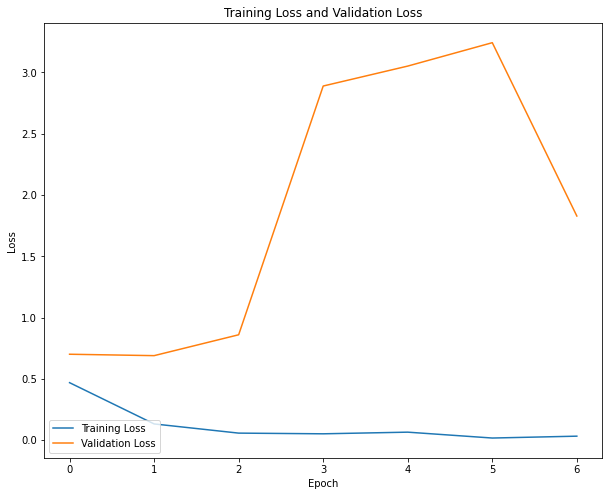

In [ ]:
N = 7

plt.figure(figsize=(10, 8))

plt.plot(np.arange(0, N), HR.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("LossPlotWMF.png")

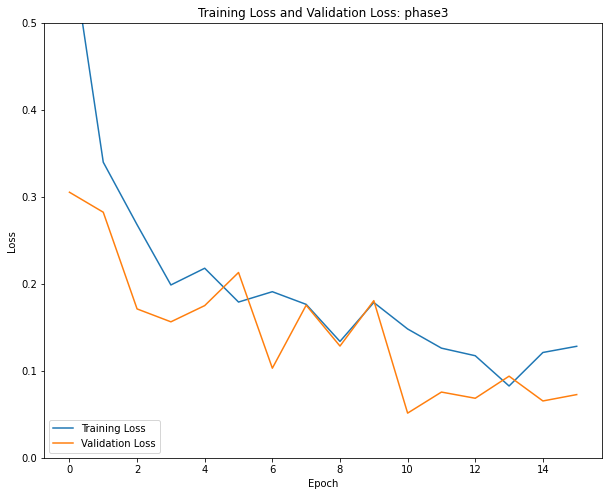

In [ ]:
N = 16

plt.figure(figsize=(10, 8))

plt.plot(np.arange(0, N), final_VGG_history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), final_VGG_history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss: phase3")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, .5)
plt.legend(loc="lower left")
plt.savefig("final_VGG.png")